### Spaceship Titanic with fastai

Competition [Link](https://www.kaggle.com/competitions/spaceship-titanic/overview)

In [1]:
#|default_exp app

In [2]:
#The Following cell of code is used everytime FASTAI library is used.
#They tell the notebook to reload any changes made to any libraries used.
#They also ensure that any graphs are plotted are shown in this notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Imports

In [3]:
from fastai.tabular.all import *
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
import dtreeviz

### Import Datasets and Create Dataframe

In [4]:
#| export
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
creds = ''

In [5]:
#| export
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [6]:
#| export
path = Path('spaceship-titanic')

In [7]:
#| export
if not iskaggle and not path.exists():
    import zipfile, kaggle
    kaggle.api.competition_download_cli(str(path))    
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [8]:
#| export
if iskaggle:
    path = Path('../input/spaceship-titanic')
    ! pip install -q dataset

Import CSV's as Pandas Dataframes

In [9]:
#| export
df = pd.read_csv(path/'train.csv', low_memory=False)
test_df = pd.read_csv(path/'test.csv', low_memory=False)
sample_df = pd.read_csv(path/'sample_submission.csv', low_memory=False)

In [10]:
df.head(n=15)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


Dropping the name, on a small dataset it could cause overfitting. Maybe we could use it to create *family groups*, but for now we'll just go with the similar-but-not-quite-the-same *boarding_groups*

In [111]:
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,group_num,group_size,deck,room_num,side
0,0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,0001,01,B,0,P
1,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,0002,01,F,0,S
2,0003_01,Europa,0,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,0003,01,A,0,S
3,0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,0003,02,A,0,S
4,0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,0004,01,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,0,A/98/P,55 Cancri e,41.0,1,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,0,9276,01,A,98,P
8689,9278_01,Earth,1,G/1499/S,PSO J318.5-22,18.0,0,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,0,9278,01,G,1499,S
8690,9279_01,Earth,0,G/1500/S,TRAPPIST-1e,26.0,0,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,1,9279,01,G,1500,S
8691,9280_01,Europa,0,E/608/S,55 Cancri e,32.0,0,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,0,9280,01,E,608,S


In [113]:
df = df.drop(['Name'], axis=1)

In [115]:
df.index

RangeIndex(start=0, stop=8693, step=1)

<AxesSubplot: >

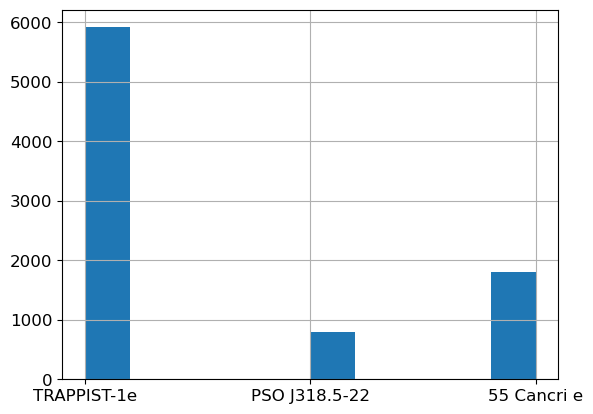

In [11]:
df['Destination'].hist()

<AxesSubplot: >

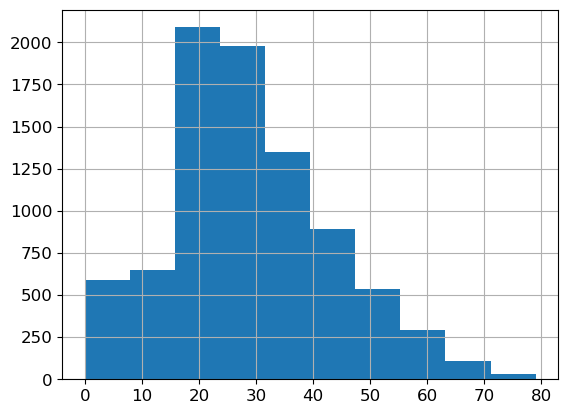

In [12]:
df['Age'].hist()

<AxesSubplot: >

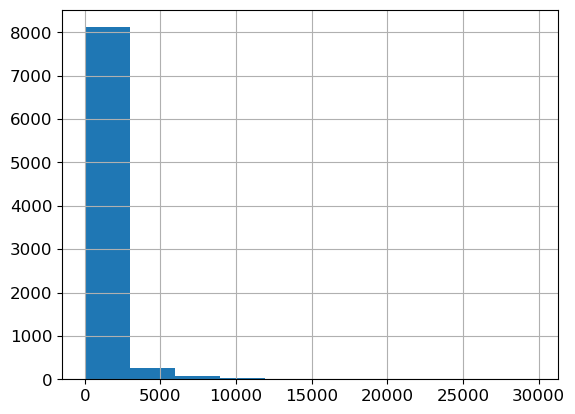

In [13]:
df['FoodCourt'].hist()

Looking at this there's some extra data we can extract to new columns, *PassengerId* looks like it's by group number and the number in a particular group, split with an underscore `_` 

In [14]:
df['PassengerId'].value_counts

<bound method IndexOpsMixin.value_counts of 0       0001_01
1       0002_01
2       0003_01
3       0003_02
4       0004_01
         ...   
8688    9276_01
8689    9278_01
8690    9279_01
8691    9280_01
8692    9280_02
Name: PassengerId, Length: 8693, dtype: object>

In [15]:
df['group_num'] = df['PassengerId'].str.split('_').str[0]
df['group_size'] = df['PassengerId'].str.split('_').str[1]

The same is true for the Cabin, there are 3 different values to analyze here, so let's split them up as well

In [16]:
df['deck'] = df['Cabin'].str.split('/').str[0]
df['room_num'] = df['Cabin'].str.split('/').str[1]
df['side'] = df['Cabin'].str.split('/').str[2]

In [17]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,group_num,group_size,deck,room_num,side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,02,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,01,F,1,S


In [18]:
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
group_num         0
group_size        0
deck            199
room_num        199
side            199
dtype: int64

In [19]:
def get_null_counts(df):
    null_count_df = pd.DataFrame((df.isnull().sum()).sort_values(ascending=False).reset_index())
    null_count_df.columns = ['column_name','null_counts']
    null_count_df = null_count_df.query("column_name!='Transported'")
    return null_count_df

null_= get_null_counts(df)
null_.style.background_gradient(cmap='summer')

,column_name,null_counts
0,CryoSleep,217
1,ShoppingMall,208
2,VIP,203
3,HomePlanet,201
4,Name,200
5,room_num,199
6,deck,199
7,side,199
8,Cabin,199
9,VRDeck,188


In [20]:
df['Transported'].value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

Add a function to convert boolean values to 0 and 1 using `LabelEncoder` 

In [21]:
def bool_switch(df, col_name):
    encoder = LabelEncoder()
    df[f'{col_name}'] = encoder.fit_transform(df[f'{col_name}']) 

In [22]:
bool_switch(df, col_name='Transported')
bool_switch(df, col_name='VIP')
bool_switch(df, col_name='CryoSleep')


Check to see how it worked

In [23]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,group_num,group_size,deck,room_num,side
0,0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,0001,01,B,0,P
1,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,0002,01,F,0,S
2,0003_01,Europa,0,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,0003,01,A,0,S
3,0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,0003,02,A,0,S
4,0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,0004,01,F,1,S


In [24]:
df['Transported'].value_counts()

1    4378
0    4315
Name: Transported, dtype: int64

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8693 non-null   int64  
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8693 non-null   int64  
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   int64  
 14  group_num     8693 non-null   object 
 15  group_size    8693 non-null   object 
 16  deck          8494 non-null   object 
 17  room_num      8494 non-null   object 
 18  side          8494 non-null 

In [26]:
df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'group_num', 'group_size', 'deck', 'room_num',
       'side'],
      dtype='object')

### Preparing Data

Declare dependant variable(y-axis)

In [27]:
#| export
dep_var = 'Transported'

In [28]:
df['Destination'].sample

<bound method NDFrame.sample of 0         TRAPPIST-1e
1         TRAPPIST-1e
2         TRAPPIST-1e
3         TRAPPIST-1e
4         TRAPPIST-1e
            ...      
8688      55 Cancri e
8689    PSO J318.5-22
8690      TRAPPIST-1e
8691      55 Cancri e
8692      TRAPPIST-1e
Name: Destination, Length: 8693, dtype: object>

Add tabular processes to transform categorical variables to something similar to `pd.Categorical`, and fill in missing/na values

In [29]:
#| export
procs = [Categorify, FillMissing, Normalize]

Split our data set into a training(.8) and a validation(.2) set, set random_state to a fixed seed for consistency

In [30]:
# #| export
# train, valid = train_test_split(df, test_size=.2, random_state=42)

Use `cont_cat_split` to separate continuous and categorical variables

In [31]:
#| export
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

Load our dataframe to a `TabularPandas` object, `procs` from above is applied here. Set the dependant variable as the target

In [109]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var,  y_block=CategoryBlock(), splits=RandomSplitter(valid_pct=0.2, seed=42)(df)).dataloaders(bs=128)

In [33]:
len(to.train), len(to.valid)

(6955, 1738)

Pickle our tabular object so that we can skip a few steps in the future

In [34]:
save_pickle(path/'space_titan_to.pkl', to)

Load our Pickle file

In [35]:
to = load_pickle(path/'space_titan_to.pkl')

The tabular pandas object has taken care of a few things, such as converting all our categories to numbers, filling missing values, and creating corresponding columns that indicateds whether a missing value was filled in

In [36]:
to.items.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,group_num,group_size,deck,room_num,side,Age_na,RoomService_na,FoodCourt_na,ShoppingMall_na,Spa_na,VRDeck_na
8388,8389,3,-0.749109,3242,3,1.612332,-0.206029,1.470626,-0.282769,-0.267182,-0.267988,-0.263122,2424,0,6005,1,6,786,2,1,1,1,1,1,1
1917,1918,1,1.095811,5560,3,-0.265485,-0.206029,-0.327109,-0.284032,-0.280746,-0.267988,-0.263122,0,1,1362,3,7,1078,1,1,1,1,1,1,1
5173,5174,1,-0.749109,6379,2,0.012710,-0.206029,-0.327109,-0.284032,-0.246835,-0.267988,0.100366,6619,0,3719,1,7,1692,1,1,1,1,1,1,1
8246,8247,1,-0.749109,2091,2,2.377369,-0.206029,-0.327109,-0.284032,-0.145103,-0.267988,1.836428,4592,0,5905,1,5,1351,2,1,1,1,1,1,1
61,62,1,1.095811,4563,2,-2.004205,-0.206029,-0.327109,-0.284032,-0.280746,-0.267988,-0.263122,5982,1,44,1,7,3,2,1,1,1,1,1,1


In [37]:
to.items.isna().sum()

PassengerId        0
HomePlanet         0
CryoSleep          0
Cabin              0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Name               0
Transported        0
group_num          0
group_size         0
deck               0
room_num           0
side               0
Age_na             0
RoomService_na     0
FoodCourt_na       0
ShoppingMall_na    0
Spa_na             0
VRDeck_na          0
dtype: int64

In [38]:
to.items.describe()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,group_num,group_size,deck,room_num,side,Age_na,RoomService_na,FoodCourt_na,ShoppingMall_na,Spa_na,VRDeck_na
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,4347.000000,1.626711,-0.012457,3078.663407,2.431497,-0.001875,0.006155,-0.005811,-0.000839,0.006771,-0.007960,0.006567,4137.292649,0.503624,3112.468423,1.517773,5.183941,926.410790,1.470378,1.020591,1.020821,1.021051,1.023927,1.021051,1.021627
std,2509.597278,0.827623,0.993203,2008.847080,0.886083,0.997427,1.017904,0.964613,1.007765,1.013948,0.960896,1.025476,2499.751656,0.500016,1797.308796,1.054241,1.928570,518.416607,0.543084,0.142020,0.142794,0.143564,0.152832,0.143564,0.145469
min,1.000000,0.000000,-0.749109,0.000000,0.000000,-2.004205,-0.206029,-0.327109,-0.284032,-0.280746,-0.267988,-0.263122,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2174.000000,1.000000,-0.749109,1185.000000,2.000000,-0.613229,-0.206029,-0.327109,-0.284032,-0.280746,-0.267988,-0.263122,1968.000000,0.000000,1553.000000,1.000000,4.000000,476.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,4347.000000,1.000000,-0.749109,3045.000000,3.000000,-0.126388,-0.206029,-0.327109,-0.284032,-0.280746,-0.267988,-0.263122,4133.000000,1.000000,3116.000000,1.000000,6.000000,992.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,6520.000000,2.000000,1.095811,4860.000000,3.000000,0.569100,-0.206029,-0.267233,-0.245510,-0.243444,-0.222742,-0.226954,6303.000000,1.000000,4631.000000,2.000000,7.000000,1328.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,8693.000000,3.000000,2.940731,6560.000000,3.000000,3.490149,5.891563,20.595846,18.543309,39.550979,18.861789,21.557912,8473.000000,1.000000,6217.000000,8.000000,8.000000,1817.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [39]:
to.train.xs

,PassengerId,HomePlanet,Cabin,Destination,Name,group_num,group_size,deck,room_num,side,Age_na,RoomService_na,FoodCourt_na,ShoppingMall_na,Spa_na,VRDeck_na,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
8388,8389,3,3242,3,2424,6005,1,6,786,2,1,1,1,1,1,1,-0.749109,1.612332,-0.206029,1.470626,-0.282769,-0.267182,-0.267988,-0.263122
1917,1918,1,5560,3,0,1362,3,7,1078,1,1,1,1,1,1,1,1.095811,-0.265485,-0.206029,-0.327109,-0.284032,-0.280746,-0.267988,-0.263122
5173,5174,1,6379,2,6619,3719,1,7,1692,1,1,1,1,1,1,1,-0.749109,0.012710,-0.206029,-0.327109,-0.284032,-0.246835,-0.267988,0.100366
8246,8247,1,2091,2,4592,5905,1,5,1351,2,1,1,1,1,1,1,-0.749109,2.377369,-0.206029,-0.327109,-0.284032,-0.145103,-0.267988,1.836428
61,62,1,4563,2,5982,44,1,7,3,2,1,1,1,1,1,1,1.095811,-2.004205,-0.206029,-0.327109,-0.284032,-0.280746,-0.267988,-0.263122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4489,4490,3,4518,3,3321,3210,4,6,1788,1,1,1,1,1,1,1,1.095811,-1.586912,-0.206029,-0.327109,-0.284032,-0.280746,-0.267988,-0.263122
2308,2309,1,3865,3,5332,1660,1,6,1281,1,1,1,1,1,1,1,-0.749109,-0.195937,-0.206029,0.479024,-0.162781,-0.229880,-0.267988,-0.262217
6485,6486,2,401,1,6910,4608,2,2,1000,2,1,1,1,1,1,1,1.095811,0.082259,-0.206029,-0.327109,-0.284032,-0.280746,-0.267988,-0.263122
2770,2771,3,1554,3,7398,2004,1,5,929,2,1,1,1,1,1,1,-0.749109,-0.960973,-0.206029,8.013157,-0.284032,3.985243,-0.267988,0.975631


<AxesSubplot: >

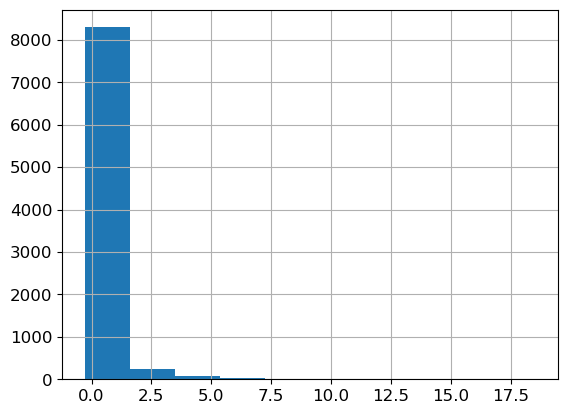

In [40]:
to['FoodCourt'].hist()

In [41]:
to.items.describe()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,group_num,group_size,deck,room_num,side,Age_na,RoomService_na,FoodCourt_na,ShoppingMall_na,Spa_na,VRDeck_na
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,4347.000000,1.626711,-0.012457,3078.663407,2.431497,-0.001875,0.006155,-0.005811,-0.000839,0.006771,-0.007960,0.006567,4137.292649,0.503624,3112.468423,1.517773,5.183941,926.410790,1.470378,1.020591,1.020821,1.021051,1.023927,1.021051,1.021627
std,2509.597278,0.827623,0.993203,2008.847080,0.886083,0.997427,1.017904,0.964613,1.007765,1.013948,0.960896,1.025476,2499.751656,0.500016,1797.308796,1.054241,1.928570,518.416607,0.543084,0.142020,0.142794,0.143564,0.152832,0.143564,0.145469
min,1.000000,0.000000,-0.749109,0.000000,0.000000,-2.004205,-0.206029,-0.327109,-0.284032,-0.280746,-0.267988,-0.263122,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2174.000000,1.000000,-0.749109,1185.000000,2.000000,-0.613229,-0.206029,-0.327109,-0.284032,-0.280746,-0.267988,-0.263122,1968.000000,0.000000,1553.000000,1.000000,4.000000,476.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,4347.000000,1.000000,-0.749109,3045.000000,3.000000,-0.126388,-0.206029,-0.327109,-0.284032,-0.280746,-0.267988,-0.263122,4133.000000,1.000000,3116.000000,1.000000,6.000000,992.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,6520.000000,2.000000,1.095811,4860.000000,3.000000,0.569100,-0.206029,-0.267233,-0.245510,-0.243444,-0.222742,-0.226954,6303.000000,1.000000,4631.000000,2.000000,7.000000,1328.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,8693.000000,3.000000,2.940731,6560.000000,3.000000,3.490149,5.891563,20.595846,18.543309,39.550979,18.861789,21.557912,8473.000000,1.000000,6217.000000,8.000000,8.000000,1817.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


Assign our X values and Y value for training and validation

In [42]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

/tmp/ipykernel_14074/3888966817.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<AxesSubplot: >

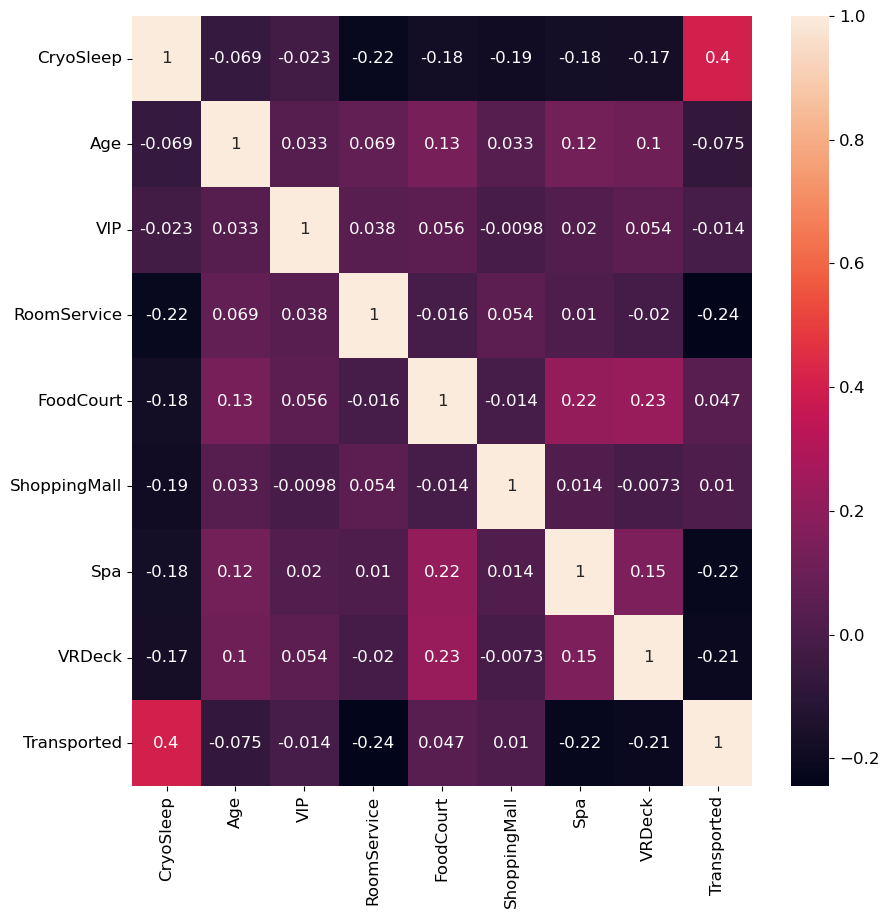

In [43]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)

### Decision Tree Classifier

Test a small tree with 4 leaf nodes

In [44]:
m = DecisionTreeClassifier(max_leaf_nodes=4)
m.fit(xs, y);

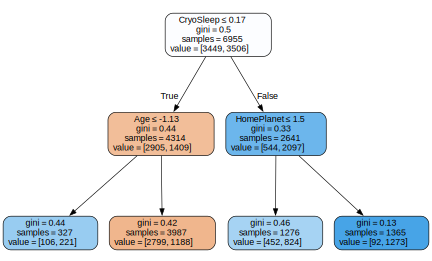

In [45]:
draw_tree(m, xs, size=6, leaves_parallel=True, precision=2)

Have the model run predictions on the validation set for who would be transported

In [46]:
y_pred = m.predict(valid_xs)

In [47]:
y_pred

array([0, 1, 1, ..., 1, 0, 1], dtype=int8)

Check how accurate our predictions were against the actual validation data

In [48]:
accuracy = accuracy_score(valid_y, y_pred)
accuracy

0.7307249712313003

In [49]:
samp_idx = np.random.permutation(len(y))[:500]

In [50]:
viz_model = dtreeviz.model(m, X_train=xs.iloc[samp_idx], y_train=y.iloc[samp_idx], target_name=dep_var)

/home/petewin/mambaforge/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


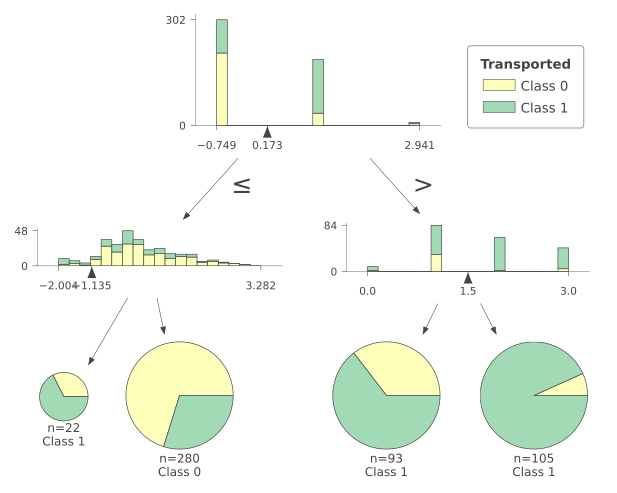

In [51]:
viz_model.view(fontname="DejaVu Sans", scale=1.8, label_fontsize=10)

In [52]:
viz_model = dtreeviz.model(m, X_train=xs, y_train=y, target_name=dep_var)

/home/petewin/mambaforge/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


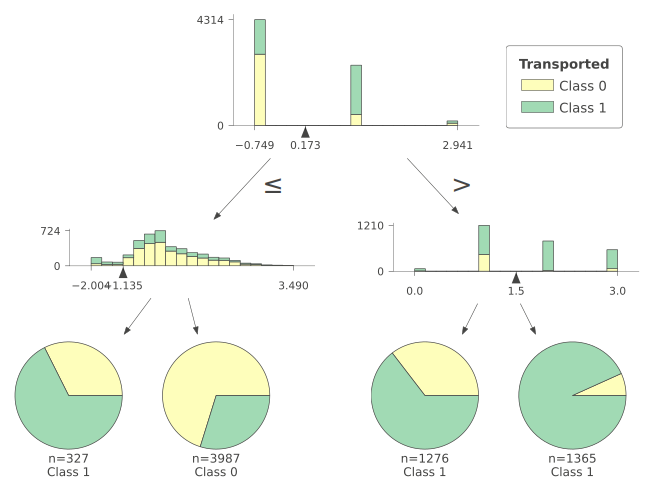

In [53]:
viz_model.view(fontname="DejaVu Sans", scale=1.8, label_fontsize=10)

### Logistic Regression

Run the same test with a quick logistic regression model

In [54]:
m = LogisticRegression(max_iter=1000)
m.fit(xs, y);

/home/petewin/mambaforge/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [55]:
y_pred = m.predict(valid_xs)

In [56]:
accuracy = accuracy_score(valid_y, y_pred)
accuracy

0.7784810126582279

### All Leaves Decision Tree 

Run the same decision tree model, let it max out the leaves until there is one for each

In [57]:
m = DecisionTreeClassifier()
m.fit(xs, y);

In [58]:
y_pred = m.predict(valid_xs)

In [59]:
accuracy = accuracy_score(valid_y, y_pred)
accuracy

0.7307249712313003

In [60]:
m.get_n_leaves(), len(xs)

(1065, 6955)

### 25 Leaves Decision Tree 

Scale back to 25 Leaves as a happy medium

In [61]:
m = DecisionTreeClassifier(min_samples_leaf=25)
m.fit(xs, y);

In [62]:
y_pred = m.predict(valid_xs)

In [63]:
accuracy = accuracy_score(valid_y, y_pred)
accuracy

0.7807825086306099

### Random Forest

Create a function to make it easier to try several variations in succession

In [64]:
def rf(xs, y, n_estimators=40, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_features=max_features, min_samples_leaf=min_samples_leaf, 
        oob_score=True).fit(xs,y)

In [65]:
m = rf(xs,y)

In [66]:
def pred_acc(m, valid_xs=valid_xs):
    y_pred = m.predict(valid_xs)
    accuracy = accuracy_score(valid_y, y_pred)
    return accuracy
    

In [67]:
pred_acc(m)

0.8055235903337169

In [68]:
preds = np.stack([t.predict(valid_xs.values) for t in m.estimators_])

In [69]:
valid_y.values

array([0, 1, 1, ..., 1, 1, 1], dtype=int8)

In [70]:
preds = np.stack([t.predict(valid_xs.values) for t in m.estimators_])

In [71]:
preds.shape

(40, 1738)

In [72]:
preds_std = preds.std(0)

In [73]:
preds_std[:5]

array([0.4769696 , 0.        , 0.48989795, 0.        , 0.21794495])

In [74]:
def rf_feat_importances(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

In [75]:
fi = rf_feat_importances(m, xs)
fi

,cols,imp
16,CryoSleep,0.199200
19,RoomService,0.112117
22,Spa,0.094768
23,VRDeck,0.086604
2,Cabin,0.070071
20,FoodCourt,0.066296
4,Name,0.051663
17,Age,0.051285
8,room_num,0.050038
0,PassengerId,0.039567


In [76]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

<AxesSubplot: ylabel='cols'>

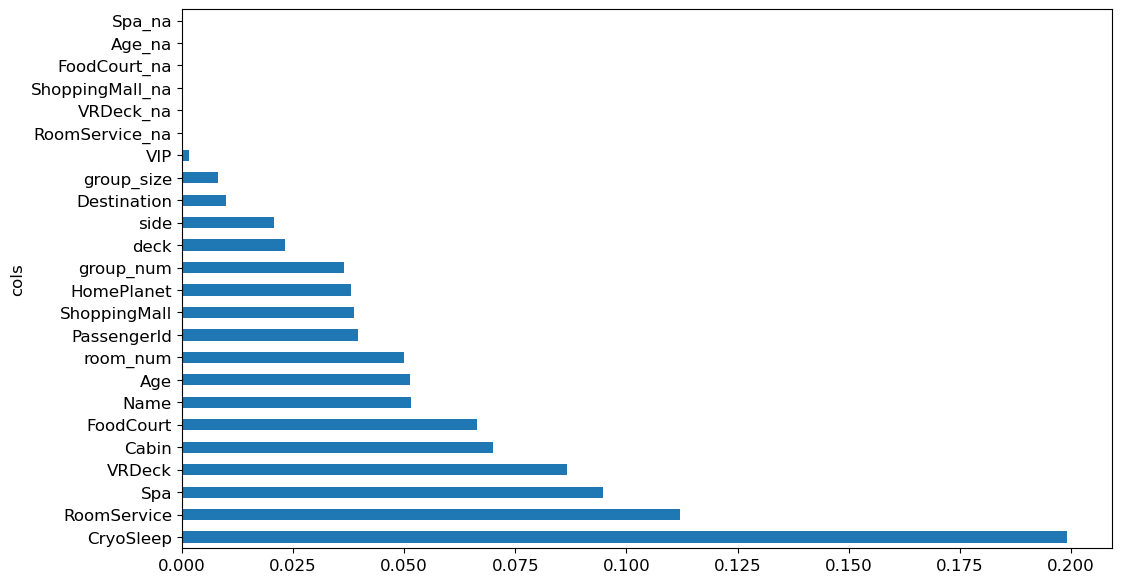

In [77]:
plot_fi(fi)

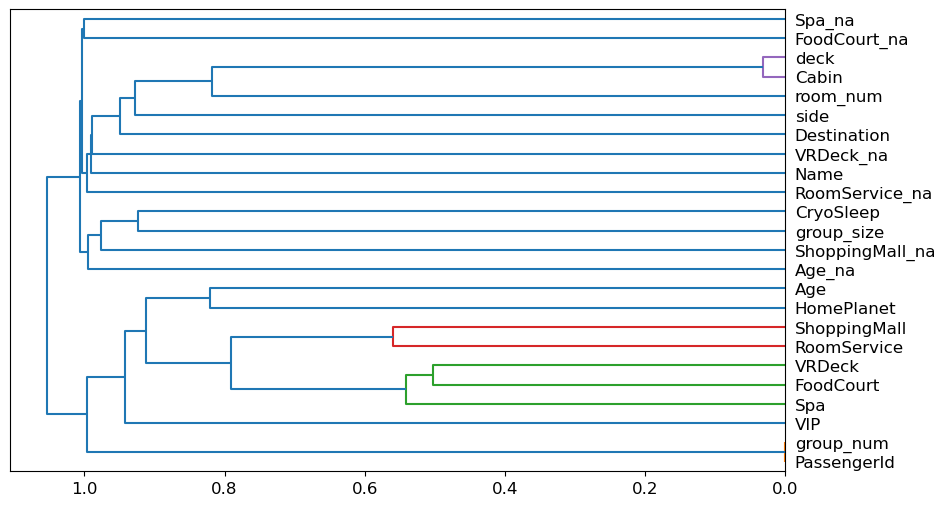

In [78]:
cluster_columns(xs)

### Removing Low Importance Variables

In [79]:
to_keep = fi[fi.imp > 0.005].cols
len(to_keep), len(fi)

(17, 24)

In [80]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [81]:
m = rf(xs_imp, y)

In [82]:
pred_acc(m, valid_xs=valid_xs_imp)

0.8037974683544303

<AxesSubplot: ylabel='cols'>

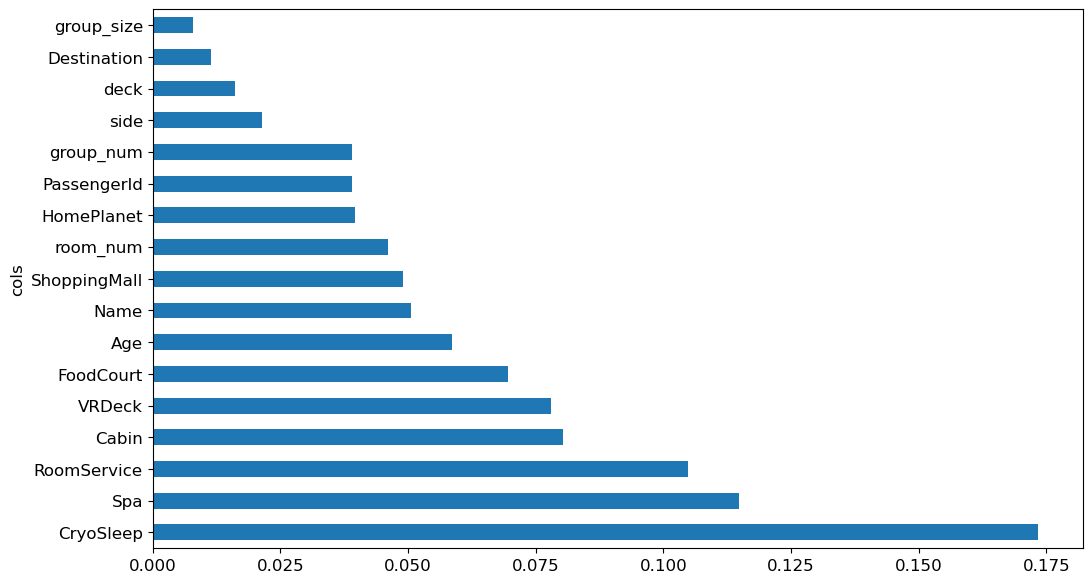

In [83]:
plot_fi(rf_feat_importances(m, xs_imp))

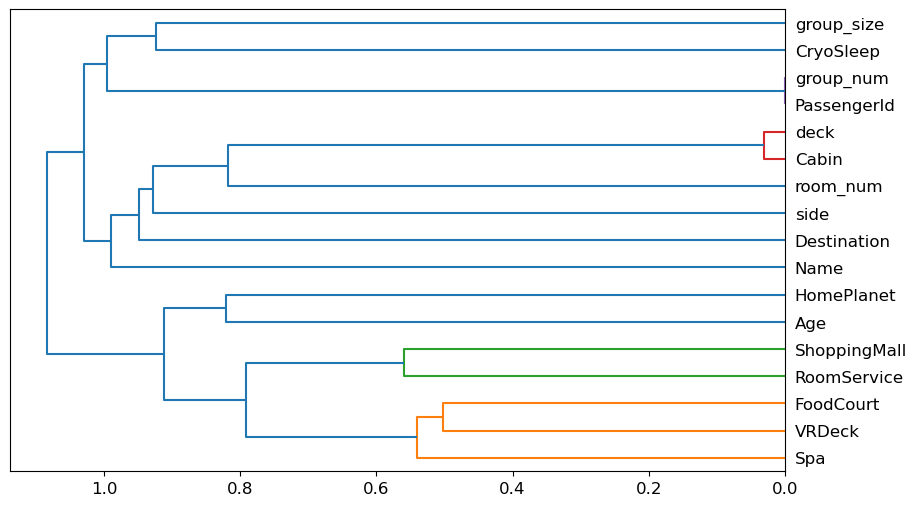

In [84]:
cluster_columns(xs_imp)

In [85]:
def get_oob(df):
    m = RandomForestClassifier(n_estimators=40, min_samples_leaf=15, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [86]:
get_oob(xs_imp)

0.796549245147376

In [87]:
xs_imp.columns

Index(['CryoSleep', 'RoomService', 'Spa', 'VRDeck', 'Cabin', 'FoodCourt',
       'Name', 'Age', 'room_num', 'PassengerId', 'ShoppingMall', 'HomePlanet',
       'group_num', 'deck', 'side', 'Destination', 'group_size'],
      dtype='object')

In [88]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in xs_imp.columns}

{'CryoSleep': 0.7916606757728253,
 'RoomService': 0.7942487419122933,
 'Spa': 0.7833213515456506,
 'VRDeck': 0.7905104241552839,
 'Cabin': 0.7915168943206327,
 'FoodCourt': 0.79568655643422,
 'Name': 0.7920920201294033,
 'Age': 0.7949676491732567,
 'room_num': 0.7945363048166787,
 'PassengerId': 0.7936736161035226,
 'ShoppingMall': 0.7932422717469446,
 'HomePlanet': 0.7962616822429907,
 'group_num': 0.7953989935298347,
 'deck': 0.796117900790798,
 'side': 0.7920920201294033,
 'Destination': 0.7913731128684399,
 'group_size': 0.8050323508267434}

In [89]:
{c:get_oob(xs.drop(c, axis=1)) for c in xs.columns}

{'PassengerId': 0.7971243709561466,
 'HomePlanet': 0.7962616822429907,
 'Cabin': 0.796117900790798,
 'Destination': 0.7959741193386053,
 'Name': 0.796549245147376,
 'group_num': 0.8005751258087707,
 'group_size': 0.7985621854780733,
 'deck': 0.7949676491732567,
 'room_num': 0.7968368080517613,
 'side': 0.7975557153127246,
 'Age_na': 0.7936736161035226,
 'RoomService_na': 0.79352983465133,
 'FoodCourt_na': 0.7932422717469446,
 'ShoppingMall_na': 0.791804457225018,
 'Spa_na': 0.7972681524083394,
 'VRDeck_na': 0.7964054636951833,
 'CryoSleep': 0.7933860531991374,
 'Age': 0.7928109273903666,
 'VIP': 0.7981308411214953,
 'RoomService': 0.792235801581596,
 'FoodCourt': 0.7962616822429907,
 'ShoppingMall': 0.794392523364486,
 'Spa': 0.7792954708842559,
 'VRDeck': 0.7866283249460819}

In [90]:
to_drop = ['group_num', 'deck', 'Name', 'group_size']

In [91]:
get_oob(xs_imp.drop(to_drop, axis=1))

0.8010064701653486

In [92]:
to_drop = ['Name']

In [93]:
get_oob(xs_imp.drop(to_drop, axis=1))

0.792667145938174

In [94]:
get_oob(xs)

0.7981308411214953

In [95]:
get_oob(xs_imp)

0.7964054636951833

In [96]:
xs_final = xs_imp
valid_xs_final = valid_xs_imp

In [97]:
save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

In [98]:
xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')

In [99]:
xs_final.head()

,CryoSleep,RoomService,Spa,VRDeck,Cabin,FoodCourt,Name,Age,room_num,PassengerId,ShoppingMall,HomePlanet,group_num,deck,side,Destination,group_size
8388,-0.749109,1.470626,-0.267988,-0.263122,3242,-0.282769,2424,1.612332,786,8389,-0.267182,3,6005,6,2,3,1
1917,1.095811,-0.327109,-0.267988,-0.263122,5560,-0.284032,0,-0.265485,1078,1918,-0.280746,1,1362,7,1,3,3
5173,-0.749109,-0.327109,-0.267988,0.100366,6379,-0.284032,6619,0.012710,1692,5174,-0.246835,1,3719,7,1,2,1
8246,-0.749109,-0.327109,-0.267988,1.836428,2091,-0.284032,4592,2.377369,1351,8247,-0.145103,1,5905,5,2,2,1
61,1.095811,-0.327109,-0.267988,-0.263122,4563,-0.284032,5982,-2.004205,3,62,-0.280746,1,44,7,2,2,1


In [100]:
pred_acc(m, valid_xs=valid_xs_final)

0.8037974683544303

### Tabular Learner Test

In [106]:
learn = tabular_learner(to, metrics=[accuracy, error_rate], layers=[170,100])

SuggestedLRs(slide=0.04786301031708717, valley=0.0014454397605732083)

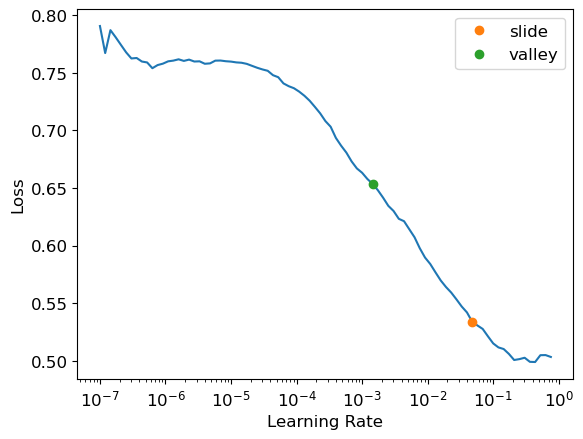

In [107]:
learn.lr_find(suggest_funcs=(slide, valley))

In [ ]:
to

      PassengerId  HomePlanet  CryoSleep  Cabin  Destination       Age  \
2333         2334           1  -0.735289      0            3 -0.055214   
2589         2590           1  -0.735289   3953            3 -0.824809   
8302         8303           2   1.121356    933            1 -0.055214   
8177         8178           3  -0.735289   3334            3 -0.614920   
500           501           2   1.121356    720            1  0.504492   
...           ...         ...        ...    ...          ...       ...   
7175         7176           1   1.121356   4913            3 -0.894772   
3187         3188           1   1.121356   5889            3 -2.014184   
1302         1303           1  -0.735289   1418            3 -0.824809   
5934         5935           3   1.121356   2632            3  0.924271   
6093         6094           1  -0.735289   4636            3 -0.824809   

           VIP  RoomService  FoodCourt  ShoppingMall       Spa    VRDeck  \
2333 -0.207316    -0.326853  -0.251